In [10]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
%cd /Midgard/home/amirme/an_explanation_model

/Midgard/home/amirme/an_explanation_model


In [5]:
x = np.linspace(0, 2, 100)
a = np.array([.1, .2, .3])
f = lambda x,a: x*x*np.exp(-2*np.pi*np.pi*a*x*x) * np.power(a, 3/2) 
y = np.array([f(x, a_i) for a_i in a])

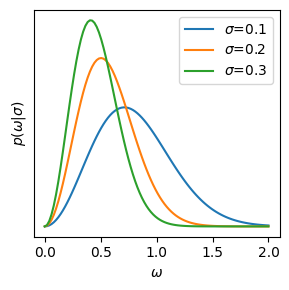

In [11]:
fig,ax = plt.subplots(1, 1, figsize=(3, 3))
for i in range(len(a)):
    ax.plot(x, y[i], label=r'$\sigma$'+f'={a[i]:.1f}')
ax.legend()

ax.set_ylabel(r'$p(\omega|\sigma)$')
ax.set_yticks([])
ax.set_xlabel(r'$\omega$')
plt.tight_layout()

plt.savefig('outputs/visual/gaussian.pdf')